In [1]:
import torch
import torch_scatter
import pickle
import random
import datetime

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

from urllib.parse import unquote
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import Dataset, random_split
from dataclasses import dataclass
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, GraphNorm, LayerNorm

ModuleNotFoundError: No module named 'torch_scatter'

### Load the text data

In [ ]:
data = pd.read_csv(f"../../data/full_text_data.csv")
data

,title,plain_text
0,Áedán_mac_Gabráin,Áedán mac Gabráin\n\n2007 Schools Wikipedia Se...
1,Åland,Åland\n\n2007 Schools Wikipedia Selection. Rel...
2,Édouard_Manet,Édouard Manet\n\n2007 Schools Wikipedia Select...
3,Éire,Éire\n\n2007 Schools Wikipedia Selection. Rela...
4,Óengus_I_of_the_Picts,Óengus I of the Picts\n\n2007 Schools Wikipedi...
...,...,...
4599,Zionism,Zionism\n\n2007 Schools Wikipedia Selection. R...
4600,Zirconium,Zirconium\n\n2007 Schools Wikipedia Selection....
4601,Zoroaster,Zoroaster\n\n2007 Schools Wikipedia Selection....
4602,Zuid-Gelders,Zuid-Gelders\n\n2007 Schools Wikipedia Selecti...


### Load the links

In [ ]:
links = pd.read_csv("../../data/Wikispeedia/links.tsv", sep="\t", names=["src", "tgt"], skiprows=12)
links

,src,tgt
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
...,...,...
119877,Zulu,South_Africa
119878,Zulu,Swaziland
119879,Zulu,United_Kingdom
119880,Zulu,Zambia


#### Create an adjacency matrix from the links

In [ ]:
links["src"] = links["src"].map(lambda x: unquote(x))
links["tgt"] = links["tgt"].map(lambda x: unquote(x))

ordered_data_titles = data["title"].tolist()

src_indices = links["src"].map(lambda x: ordered_data_titles.index(x))
tgt_indices = links["tgt"].map(lambda x: ordered_data_titles.index(x))

A = torch.zeros((len(ordered_data_titles), len(ordered_data_titles)))
A[src_indices, tgt_indices] = 1

A  # This is the base structure of the Wikipedia network

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

### Load the coherence graph

In [ ]:
with open("../../data/coherence_graph.pkl", 'rb') as handle:
    coherence_graph = pickle.load(handle)
    print(f"Coherence graph loaded successfully.")

coherence_graph

Coherence graph loaded successfully.


array([[0.        , 0.33138034, 0.31785333, ..., 0.33416559, 0.3096299 ,
        0.3338204 ],
       [0.33138034, 0.        , 0.31811661, ..., 0.59573573, 0.34740373,
        0.66406903],
       [0.31785333, 0.31811661, 0.        , ..., 0.32476778, 0.30271915,
        0.32060009],
       ...,
       [0.33416559, 0.59573573, 0.32476778, ..., 0.        , 0.31785316,
        0.67388399],
       [0.3096299 , 0.34740373, 0.30271915, ..., 0.31785316, 0.        ,
        0.33336595],
       [0.3338204 , 0.66406903, 0.32060009, ..., 0.67388399, 0.33336595,
        0.        ]])

### Combine the Coherence Graph and Base Links to form Semantic Network

In [ ]:
edge_features = A * coherence_graph
edge_features  # This is the base structure of the Wikipedia network, with coherence scores as edge features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

### Load the Node Features (OpenAI Embeddings)

In [ ]:
with open("../../data/gpt4_embeddings.pkl", 'rb') as handle:
    obj = pickle.load(handle)
    node_static_embeddings = obj["embeddings"]
    del obj
    print(f"File '../../data/gpt4_embeddings.pkl' loaded successfully.")

File '../../data/gpt4_embeddings.pkl' loaded successfully.


### Load the User-Extracted Paths

In [ ]:
paths_data = pd.read_csv(f"../../data/paths_no_back_links.tsv", sep="\t")
paths_data_no_na = paths_data[~(paths_data["rating"].isna())]

# # ------------------------ Sampling paths with N/A ratings as Rated ------------------------
# paths_data_with_na = paths_data[(paths_data["rating"].isna())]
# long_paths_with_na = paths_data_with_na[paths_data_with_na["path"].apply(lambda x: len(set(x.split(";")))) >= 6]

# # Paths with length 6 and with N/A ratings are rated 4
# long_paths_with_na.loc[long_paths_with_na["path"].apply(lambda x: len(set(x.split(";")))) == 6, "rating"] = 4

# # Paths with length greater 7 and with N/A ratings are rated 5
# long_paths_with_na.loc[long_paths_with_na["path"].apply(lambda x: len(set(x.split(";")))) > 7, "rating"] = 5

# paths_data = pd.concat([paths_data_no_na, long_paths_with_na])
# # ------------------------ Sampling paths with N/A ratings as Rated ------------------------

paths_data = paths_data_no_na

paths_data

,hashedIpAddress,timestamp,durationInSec,path,rating
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
6,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire,2.0
7,20418ff4797f96be,1229188046,139,14th_century;Time;Isaac_Newton;Light;Color;Rai...,1.0
8,08888b1b428dd90e,1232241510,74,14th_century;Time;Light;Rainbow,3.0
...,...,...,...,...,...
51310,55150dce4acb74c8,1340891297,117,Women%27s_rights;Property;Clothing;Weather;Autumn,5.0
51311,4753cde919cd5ce5,1348670636,418,Work_%28thermodynamics%29;Energy;Aristotle;Poe...,3.0
51312,052ba30a41ff5a05,1371787558,133,Work_%28thermodynamics%29;Cambridge;City_statu...,3.0
51314,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;Folklore;19th_ce...,3.0


<Axes: >

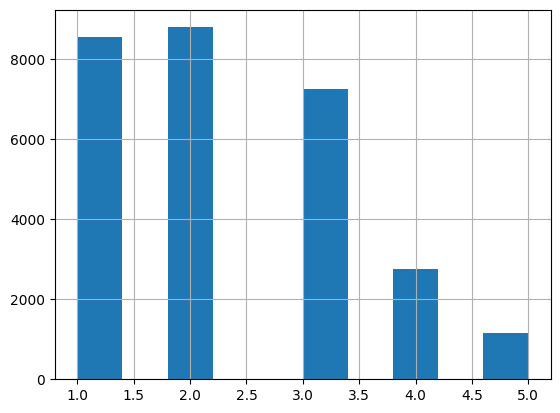

In [ ]:
paths_data["rating"].hist()

In [ ]:
# Find the minimum count of rows for any rating
# min_count = paths_data['rating'].value_counts().min()

# Perform uniform sampling for each rating
# paths_data = paths_data.groupby('rating').apply(
#     # lambda x: x.sample(min_count, replace=False, random_state=420),
#     lambda x: x.sample(min(4000, len(x)), replace=False, random_state=420),
#     include_groups=False
# ).reset_index(level=1, drop=True).reset_index()

# Only paths with that have at least two distinct pages between the source and the the target
paths_data = paths_data[paths_data["path"].apply(lambda x: len(set(x.split(";")))) >= 4]

paths_data

,hashedIpAddress,timestamp,durationInSec,path,rating
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
6,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire,2.0
7,20418ff4797f96be,1229188046,139,14th_century;Time;Isaac_Newton;Light;Color;Rai...,1.0
8,08888b1b428dd90e,1232241510,74,14th_century;Time;Light;Rainbow,3.0
...,...,...,...,...,...
51310,55150dce4acb74c8,1340891297,117,Women%27s_rights;Property;Clothing;Weather;Autumn,5.0
51311,4753cde919cd5ce5,1348670636,418,Work_%28thermodynamics%29;Energy;Aristotle;Poe...,3.0
51312,052ba30a41ff5a05,1371787558,133,Work_%28thermodynamics%29;Cambridge;City_statu...,3.0
51314,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;Folklore;19th_ce...,3.0


<Axes: >

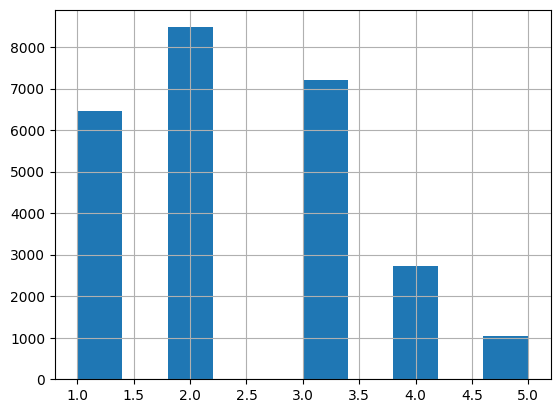

In [ ]:
paths_data["rating"].hist()

#### Map the Path Titles to Node Indices

In [ ]:
# Create a mapping from title to index
title_to_index = {unquote(title): idx for idx, title in enumerate(data['title'])}

# Convert each path to a list of indices
paths = paths_data['path'].apply(
    lambda path: [title_to_index[unquote(title)] for title in path.split(';')]
).tolist()

# Ratings start at 1. We make them 0-indexed here to be compatible with CrossEntropyLoss
ratings = (paths_data['rating'] - 1).tolist()

### Create Datasets and Data Loaders with Batched Path Subgraphs

In [ ]:
class PathDataset(Dataset):
    def __init__(self, all_padded_paths, ratings, node_static_embeddings, edge_features):
        self.all_padded_paths = all_padded_paths
        self.ratings = ratings
        self.node_static_embeddings = node_static_embeddings
        self.edge_features = edge_features

    def __len__(self):
        return len(self.all_padded_paths)

    def __getitem__(self, idx):
        path = self.all_padded_paths[idx]
        rating = self.ratings[idx]

        # Extract the 1-hop neighborhood subgraph
        neighbors, in_path, subgraph, edges = self.get_path_1hop_neighborhood(
            path,
            self.edge_features
        )

        # Get node features
        node_features = self.node_static_embeddings[neighbors]

        # Create edge index tensor
        if len(edges) > 0:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)

        # Create the Data object
        node_data = Data(
            x=node_features,
            edge_index=edge_index,
            y=torch.tensor([rating], dtype=torch.float),
            in_path=torch.tensor(in_path, dtype=torch.float),
            # We convert the subgraph to numpy to avoid issues with PyTorch's Data collation,
            # since the subgraphs have shape NxN, instead of NxD. That is they do not have
            # fixed feature dimensionality in the columns. The columns vary with the rows.
            adj=subgraph.numpy()
        )

        return node_data

    def get_path_1hop_neighborhood(self, path, edge_features, do_shuffle=False):
        path_nodes = set(path)

        # Collect 1-hop neighbors in a set to avoid duplicates
        neighbors = set()
        for node in path:
            # Get the indices of the top 4 neighbors with the highest edge weights
            top_neighbors = torch.topk(edge_features[node], k=4, largest=True).indices.tolist()
            neighbors.update(top_neighbors)

        all_nodes = list(path_nodes | neighbors)

        if do_shuffle:
            random.shuffle(all_nodes)

        # Extract subgraph using tensor indexing
        indices = torch.tensor(all_nodes)
        subgraph = edge_features.index_select(0, indices).index_select(1, indices)

        # Create a binary list indicating if each node is in the path
        is_in_path = [1 if node in path_nodes else 0 for node in all_nodes]

        # Edge list from non-zero entries in the subgraph
        edge_indices = (subgraph != 0).nonzero(as_tuple=False)
        edge_list = [(src.item(), tgt.item()) for src, tgt in edge_indices]

        return all_nodes, is_in_path, subgraph, edge_list

In [ ]:
batch_size = 6

# Define the split ratio (e.g., 85% for training, 10% for testing)
train_ratio = 0.85
val_ratio = 0.05
test_ratio = 0.1

number_of_paths = len(paths)

# Calculate the sizes of the splits
train_size = int(train_ratio * number_of_paths)
val_size = int(val_ratio * number_of_paths)
test_size = number_of_paths - train_size - val_size

print("Number of Training Samples:", train_size)
print("Number of Validation Samples:", val_size)
print("Number of Testing Samples:", test_size)

full_paths_dataset = PathDataset(
    paths,
    ratings,
    node_static_embeddings,
    edge_features,
)

# Split the dataset
train_dataset, test_dataset, val_dataset = random_split(
    dataset=full_paths_dataset,
    lengths=[train_size, test_size, val_size]
)

# Create data loaders (optional, but recommended for efficient training)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Number of Training Samples: 22009
Number of Validation Samples: 1294
Number of Testing Samples: 2590


#### Class Weights for Imbalanced Training

In [ ]:
# Counts occurrences of each class
class_counts = torch.bincount(
    torch.tensor(ratings)[train_dataset.indices].to(torch.int64)
)

# Calculate weights as the inverse of class frequencies
class_weights = 1.0 / class_counts.float()

# Normalize the weights so that they sum to the number of classes
class_weights = class_weights / class_weights.sum() * len(class_counts)

class_weights

tensor([0.4453, 0.3364, 0.3983, 1.0353, 2.7846])

## The Model

In [ ]:
class GraphSAGELayer(nn.Module):
    def __init__(self, in_feats, out_feats, bias):
        super(GraphSAGELayer, self).__init__()
        self.out_feats = out_feats
        self.linear_self = nn.Linear(in_feats, out_feats, bias=bias)
        self.linear_neigh = nn.Linear(in_feats, out_feats, bias=bias)  # +1 for edge weights
        self.output_linear = nn.Linear(2 * out_feats, out_feats, bias=bias)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # Use He (Kaiming) initialization for ReLU/Leaky ReLU activations
            torch.nn.init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='relu')
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, x, edge_index):
        num_nodes = x.size(0)

        # Compute self node embeddings
        h_self = F.leaky_relu(self.linear_self(x))  # [num_nodes, out_feats]

        # Neighbor node indices and features
        src_nodes = edge_index[0]  # Source nodes (neighbors)
        dst_nodes = edge_index[1]  # Target nodes

        # Neighbor features
        x_neigh = x[src_nodes]  # [num_edges, in_feats]

        # Linear transformation on neighbor features
        h_neigh = F.leaky_relu(self.linear_neigh(x_neigh))  # [num_edges, out_feats]

        # Aggregate neighbor messages using max pooling
        h_neigh_agg = torch_scatter.scatter_max(
            src=h_neigh,
            index=dst_nodes,
            dim=0,
            dim_size=num_nodes
        )[0]

        # Handle nodes with no incoming edges
        h_neigh_agg[h_neigh_agg == float('-inf')] = 0

        # Concatenate self and neighbor embeddings
        # [num_nodes, 2 * out_feats]
        h_concat = torch.cat([h_self, h_neigh_agg], dim=1)

        # Output transformation
        h_out = F.leaky_relu(self.output_linear(h_concat))  # [num_nodes, out_feats]

        return h_out

In [ ]:
class Model(nn.Module):
    def __init__(self, node_in_feats, k_eigen_vecs, hidden_feats, out_feats, class_feats, num_classes, dropout=0.2, bias=True):
        super(Model, self).__init__()
        self.k_eigen_vecs = k_eigen_vecs

        # Edge feature embeddings with batch normalization
        self.edge_features_embeds = nn.Linear(self.k_eigen_vecs, hidden_feats, bias=bias)
        self.edge_features_norm = GraphNorm(hidden_feats)

        # Node feature embeddings (GraphSAGE) with optional batch normalization
        self.input_node_norm = LayerNorm(node_in_feats + 1)
        self.node_features_embeds_1 = GraphSAGELayer(node_in_feats + 1 + hidden_feats, hidden_feats, bias)
        self.node_features_embeds_2 = GraphSAGELayer(hidden_feats, out_feats, bias)

        # Classifier head with batch normalization
        self.classifier_linear_1 = nn.Linear(out_feats + 1 + node_in_feats, class_feats, bias=bias)
        self.classifier_linear_norm_1 = GraphNorm(class_feats)
        self.classifier_linear_2 = nn.Linear(class_feats, class_feats, bias=bias)
        self.classifier_linear_norm_2 = GraphNorm(class_feats)
        # No bias for the output layer since our data is inbalanced. We use class weights instead.
        # This prevents the model from learning to predict the majority class.
        self.classifier_linear_3 = nn.Linear(class_feats, num_classes, bias=False)

        self.dropout_layer = nn.Dropout(p=dropout)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # Use He (Kaiming) initialization for ReLU/Leaky ReLU activations
            torch.nn.init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='relu')
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, node_features, edge_subgraph, edge_list, is_in_path, batch_mask):
        # The node features
        node_features = torch.cat((is_in_path.unsqueeze(1), node_features), dim=1)
        node_features = self.input_node_norm(node_features)

        # The edge features.
        # This is actually just an inductive bias about the strengths of the
        # connections of each node to its neighbors in the subgraph. This is
        # not directly learning anything about individual edges. However, we
        # do use the edge features to compute this inductive bias, so it learns
        # something about the aggregated edges of the node (indirectly).
        edge_embeds = []
        for subgraph in edge_subgraph:
            subgraph = torch.from_numpy(subgraph)
            s_edge_indices = (subgraph != 0).nonzero(as_tuple=False).reshape(-1, 2).t()
            eigen_vecs = self.compute_eigenvecs(subgraph, s_edge_indices, k=self.k_eigen_vecs)
            edge_embeds.append(eigen_vecs.to(torch.float32))

        edge_embeds = torch.cat(edge_embeds, dim=0)
        edge_embeds = self.edge_features_embeds(edge_embeds)
        edge_embeds = F.leaky_relu(self.edge_features_norm(edge_embeds, batch_mask))

        # The node and edge GraphSAGE embeddings
        node_edge_features = torch.cat((edge_embeds, node_features), dim=1)
        node_embeds = self.node_features_embeds_1(node_edge_features, edge_list)
        node_embeds = self.node_features_embeds_2(node_embeds, edge_list)

        # Only consider the node embeddings that are in the path
        in_path_nodes = is_in_path.to(torch.bool)
        node_embeds_in_path = node_embeds[in_path_nodes]

        # Combine the node input features and aggregated neighbor embeddings
        # Can be thought of as a form of residual connection
        h = torch.cat((node_features[in_path_nodes], node_embeds_in_path), dim=1)

        # The classifier head 1
        out = self.classifier_linear_1(h)
        out = F.leaky_relu(self.classifier_linear_norm_1(out, batch_mask[in_path_nodes]))
        out = self.dropout_layer(out)

        # The classifier head 2
        out = self.classifier_linear_2(out)
        out = F.leaky_relu(self.classifier_linear_norm_2(out, batch_mask[in_path_nodes]))
        out = self.dropout_layer(out)

        # The classifier head 3 (output layer)
        out = self.classifier_linear_3(out)
        out = self.dropout_layer(out)

        # Global mean pooling for each graph in the batch
        out = global_mean_pool(out, batch_mask[in_path_nodes])
        return out

    def compute_eigenvecs(self, subgraph, edge_index, k):
        # Build adjacency matrix A from edge_index
        A = torch.zeros((subgraph.shape[0], subgraph.shape[0]), dtype=torch.float32)
        A[edge_index[0], edge_index[1]] = 1

        # Compute the Degree matrix D
        degrees = A.sum(dim=1)
        D = torch.diag(degrees)

        # Compute the Laplacian matrix L = D - A
        L = D - subgraph

        # Compute eigenvalues and eigenvectors of L
        eigenvalues, eigenvectors = torch.linalg.eigh(L)  # eigenvalues in ascending order

        # Identify non-zero (non-trivial) eigenvalues
        eps = 1e-5  # Tolerance for zero
        non_zero_indices = (eigenvalues > eps).nonzero(as_tuple=True)[0]

        # Handle the case when there are fewer than k non-zero eigenvalues
        if len(non_zero_indices) < k:
            raise ValueError(f"Not enough non-trivial eigenvalues, got {len(non_zero_indices)}, need {k}")

        # Get the indices of the k smallest non-zero eigenvalues
        k_smallest_indices = non_zero_indices[:k]

        # Get the corresponding eigenvectors
        k_smallest_eigenvectors = eigenvectors[:, k_smallest_indices]

        return k_smallest_eigenvectors

In [ ]:
MODEL = Model(
    node_static_embeddings.shape[1],
    hidden_feats=1024,  # Hidden layer size for GraphSAGE
    k_eigen_vecs=8,  # Number of eigenvectors to compute
    out_feats=768,  # Output layer size for GraphSAGE
    class_feats=256,  # Hidden layer size for the classifier head
    num_classes=5,  # Number of classes
    bias=True, # The models learns better without bias. Maybe because the data is imbalanced.
)

## Training the Model

In [ ]:
class LitModel(L.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config

    def training_step(self, batch, batch_idx):
        logits = self.do_forward(batch)
        loss = self.compute_loss(logits, batch.y)

        loss = self.compute_loss(logits, batch.y)
        acc = self.compute_accuracy(logits, batch.y)

        # Log training loss and accuracy
        self.log("training_loss", loss, on_step=True, on_epoch=True, logger=True, batch_size=batch_size)
        self.log("training_accuracy", acc, on_step=True, on_epoch=True, logger=True, batch_size=batch_size)

        return loss

    def test_step(self, batch):
        logits = self.do_forward(batch)

        loss = self.compute_loss(logits, batch.y)
        acc = self.compute_accuracy(logits, batch.y)

        self.log("test_loss", loss, on_step=True, on_epoch=True, batch_size=batch_size)
        self.log("test_accuracy", acc, on_step=True, on_epoch=True, batch_size=batch_size)

    def validation_step(self, batch, batch_idx):
        logits = self.do_forward(batch)

        loss = self.compute_loss(logits, batch.y)
        acc = self.compute_accuracy(logits, batch.y)

        # Log validation loss and accuracy
        self.log("validation_loss", loss, on_step=True, on_epoch=True, logger=True, batch_size=batch_size)
        self.log("validation_accuracy", acc, on_step=True, on_epoch=True, logger=True, batch_size=batch_size)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            params=self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay,
            betas=(self.config.beta1, self.config.beta2),
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(optimizer),
                "interval": "epoch",
                "frequency": 1,
                "monitor": "validation_loss",
                "strict": True,
            }
        }

    def do_forward(self, batch):
        """This is a custom method not associated with Lightning"""
        return self.model(
            node_features=batch.x,
            edge_subgraph=batch.adj,
            edge_list=batch.edge_index,
            is_in_path=batch.in_path,
            batch_mask=batch.batch
        )

    def compute_loss(self, logits, targets):
        """This is a custom method not associated with Lightning"""
        targets = targets.type(torch.long)
        return F.cross_entropy(logits, targets, weight=class_weights)

    def compute_accuracy(self, logits, targets):
        """This is a custom method not associated with Lightning"""
        return (logits.argmax(1) == targets).float().mean()

In [ ]:
@dataclass
class ModelConfig:
    learning_rate: float = 1e-2
    weight_decay: float = 1e-2
    beta1: float = 0.9
    beta2: float = 0.999
    grad_clip: float = None
    num_epochs: int = 20
    log_interval: int = 1
    grad_accumulation: int = 8
    wandb_project: str = "wikispeedia_v2"


config = ModelConfig()

In [ ]:
# model
transformer = LitModel(MODEL, config)

# logging
wandb_logger = WandbLogger(
    project=config.wandb_project,
    name=datetime.datetime.now().strftime("%b-%d-%y @ %I:%M %p"),
    log_model="all",
    config=config
)

wandb_logger.watch(MODEL, log="all")

# Define the trainer
trainer = L.Trainer(
    default_root_dir="some/path/",
    max_epochs=config.num_epochs,
    val_check_interval=0.5,
    log_every_n_steps=config.log_interval,
    accumulate_grad_batches=config.grad_accumulation,
    gradient_clip_val=config.grad_clip,
    profiler="simple",
    logger=wandb_logger,
    # NOTE: Should be commented out if using GPU. There may be bugs related
    # to tensor device placements, since I have not tested this on GPU.
    accelerator="cpu",
)

# train model
trainer.fit(
    model=transformer,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: faustotnc. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/faustogerman/miniforge3/envs/geometric/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | Model | 10.8 M | train
----------------------------------------
10.8 M    Trainable params
0         Non-trainable params
10.8 M    Total params
43.097    Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s]

/Users/faustogerman/miniforge3/envs/geometric/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/faustogerman/miniforge3/envs/geometric/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 6:  50%|████▉     | 1834/3669 [02:10<02:10, 14.04it/s, v_num=sqy2]

## Testing the Model

In [ ]:
# Test the model
# trainer.test(model=transformer, dataloaders=test_loader)

In [ ]:
MODEL = MODEL.eval()
i = iter(test_loader)

In [ ]:
test_batch = next(i)

logits = MODEL(
    node_features=test_batch.x,
    edge_subgraph=test_batch.adj,
    edge_list=test_batch.edge_index,
    is_in_path=test_batch.in_path,
    batch_mask=test_batch.batch
)

logits

In [ ]:
# logits.round()
F.softmax(logits, dim=1).argmax(1)

In [ ]:
test_batch.y.int()